In [1]:
from HeaderP import *

In [2]:
def log_prior(params):
    m = params[0]
    return -1.5 * np.log(1 + m*m)

def log_marg_prob_scatter(params, S, yn, xn):
    m, b, log_lambda = params
    v = np.array([-m, 1.0])

    # Enforce the log-uniform prior on lambda. 
    if not -5.0 < log_lambda < 5.0:
        return -np.inf

    # Compute \Sigma^2 and \Delta.
    lamd = np.exp(log_lambda)
    Lambda = np.zeros((2,2))
    Lambda[0,0], Lambda[0,1], Lambda[1,0], Lambda[1,1] =  m**2, -m, -m, 1
    Lambda = Lambda * lamd**2/(1+m**2)
    Sigma2 = np.dot(np.dot(S+Lambda, v), v)
    Delta = m * xn + b - yn

    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)

#import emcee

def monoage(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5]):
    colors = getcolor(range(len(agebin)+1))
    plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        r_sing = r_sing[m2]
        feh_sing = feh_sing[m2]
        
        r_ave, feh_ave = movingMed_time(r_sing, feh_sing, 1, 0.1)
        #feh_ave = gaussian_filter(feh_ave, 4)
        """if agebin[i]==12.:
            plt.plot(r_sing, feh_sing,'.', color=colors[i], markersize=1)"""
        plt.plot(r_ave, feh_ave, color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.grid(color='grey', linestyle='-', linewidth=1)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)

def getscatt_bay(feh, r, age, feh_err, r_err, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    
    nwalkers=64
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    scatters_err = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    feherr = feh_err[m]
    rerr = r_err[m]
    
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        feh_err_sing = feherr[m]
        r_err_sing = rerr[m]
        
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                #print(agebin[i], rbins[j], sum(m))
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                feh_err_sing_2 = feh_err_sing[m]
                r_err_sing_2 = r_err_sing[m]
        
                S = np.zeros((len(feh_sing_2),2,2))
                for k in range(len(feh_sing_2)):
                    S[k,0,0] = r_err_sing_2[k]**2
                    S[k,1,1] = feh_err_sing_2[k]**2
                print(agebin[i], rbins[j], len(feh_sing_2))
                z = np.polyfit(r_err_sing_2,feh_sing_2,1)
                sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(S, feh_sing_2, r_sing_2))
                p0 = np.array([z[0], z[1], np.log(0.03)])
                p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
                pos, _, _ = sampler_scatter.run_mcmc(p0, 1000, progress=True)
                sampler_scatter.reset()
                sampler_scatter.run_mcmc(pos, 6000, progress=True)
                samples_scatter = sampler_scatter.flatchain

                """# m
                mcmc = np.percentile(samples_scatter[:, 0], [16, 50, 84])
                q = np.diff(mcmc)
                hi_m[i,0], hi_m[i,1], hi_m[i,2] = mcmc[1], q[0], q[1]

                # b
                mcmc = np.percentile(samples_scatter[:, 1], [16, 50, 84])
                q = np.diff(mcmc)
                hi_b[i,0], hi_b[i,1], hi_b[i,2] = mcmc[1], q[0], q[1]"""

                # dispersion
                mcmc = np.percentile(samples_scatter[:, 2], [16, 50, 84])
                q = np.diff(mcmc)
                scatters[i,j], dishi, dislow = mcmc[1], q[0], q[1]
                scatters_err[i,j] = np.mean(abs(dishi)+abs(dislow))

                
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters, scatters_err


def getscatt(feh, r, age, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    if len(feherr)>0:
            feherr = feherr[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        if len(feherr)>0:
            feh_err_sing = feherr[m]
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                p = fitpoints(r_sing_2, feh_sing_2) 
                scatters[i,j] = np.std(feh_sing_2-p(r_sing_2))

                if len(feherr)>0:
                    feh_err_sing_2 = feh_err_sing[m]
                    scatters[i,j] = np.sqrt(scatters[i,j]**2-np.mean(feh_err_sing_2)**2)

    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters
    
def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],plotlegend=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        plt.plot(r_sing[m2], p(r_sing[m2]), color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    if plotlegend:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)
    #plt.savefig(i+'.png')
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter
    
def getcolor(vrange, cmap=plt.cm.get_cmap('plasma')):
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    #print([cmap(norm(i)) for i in vrange])
    return [cmap(norm(i)) for i in vrange]


def avr(age, r, vz, rbin=np.linspace(6,12,4), agebin=np.linspace(0,14,10)):
    colors = getcolor(range(len(rbin)+1))
    avrs = np.zeros((len(rbin)-1, len(agebin)-1))
    for i in trange(len(rbin)-1):
        m = (r>rbin[i])&(r<rbin[i+1])
        age_r, r_r, vz_r = age[m], r[m], vz[m]
        for j in range(len(agebin)-1):
            m2 = (age_r>agebin[j])&(age_r<agebin[j+1])
            if sum(m2)<10:
                avrs[i,j]=np.nan
            else:
                vz_r_age = vz_r[m2]
                avrs[i,j] = 1.5*sum(abs(vz_r_age-np.median(vz_r_age)))/sum(m2)
    return (agebin[:-1]+agebin[1:])/2, (rbin[:-1]+rbin[1:])/2, avrs
    

# Check simiulation with a bar

In [3]:
#pd.read_pickle('../NIHAORbirth/g2.79e12_z_0_decomp.pkl').columns

In [275]:
#simNo='6_96e11'
simNo='2_79e12'
#simNo='7_55e11'
#z='0'
#z='0_097' 
#z='0_255'
z='0'
# app-center passage
#z='0_25' 
#z='0_2' 
#z='0_195' 
#z='0_19' 
#z='0_1' 
# peri-center passage
#z='0_34' 
#z='0_35' 
#z='0_36' 
Rcut=True
select=False
Rcut_thread=30
zcut_thread=5

In [276]:


if simNo=='data':
    data=pd.read_pickle('../SecondYear/CannonDR16_cut.pkl')
    data['z_today']=data['z']
    data['x_today']=data['X']
    data['y_today']=data['Y']
    data['feh_scale']=data['M_H']
    data['ofe_scale']=data['O_FE']
    data['age']=data['Age']
elif select:
    data=pd.read_pickle('Data/Buck_g'+simNo+'_apogee_selec.pkl')
    data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
    data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
    scale_fe=0.250019907951355/np.std(data['feh'])
    scale_o=0.10861970484256744/np.std(data['ofe'])
    data['feh_scale']=data['feh']*scale_fe-0.0906638577580452-np.mean(data['feh'])
    data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-np.mean(data['ofe'])
elif not select:
    if z=='0':
        data=pd.read_pickle('../SimulationData/Data/Buck_g'+simNo+'.pkl')
        #rg = pd.read_pickle('../NIHAORbirth/g'+simNo.split('_')[0]+'.'+simNo.split('_')[1]+'_z_0_decomp.pkl')
        #data = pd.merge(data, rg[['iord','Rg']], left_on='iord', right_on='iord',
        #               how='inner')
    else:
        data=pd.read_pickle('../SimulationData/Data/Buck_g'+simNo+'_z'+z+'.pkl')
        try:
            data['x_today']=data['x']
            data['y_today']=data['y']
            data['z_today']=data['z']
        except:
            print(np.shape(data['x_today']))
        
    data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
    data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
    scale_fe=0.250019907951355/np.std(data['feh'])
    scale_o=0.10861970484256744/np.std(data['ofe'])
    data['feh_scale']=data['feh']*scale_fe-0.0906638577580452-np.mean(data['feh'])
    data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-np.mean(data['ofe'])
    
# 2.79e12        
vscale = 240/340
rscale = 3.5/5.6

# 7.55e11 
#vscale = 240/181
#rscale = 3.5/4.41
data['vx'] = data['vx']*vscale
data['vy'] = data['vy']*vscale
data['vz'] = data['vz']*vscale

data['vx_birth'] = data['vx_birth']*vscale
data['vy_birth'] = data['vy_birth']*vscale
data['vz_birth'] = data['vz_birth']*vscale

data['R'] = data['R']*rscale
#data['Rg'] = data['Rg']*rscale
data['R_bir'] = data['R_bir']*rscale
data['x'] = data['x']*rscale
data['y'] = data['y']*rscale
data['z'] = data['z']*rscale

data['x_birth'] = data['x_birth']*rscale
data['y_birth'] = data['y_birth']*rscale
data['z_birth'] = data['z_birth']*rscale

data['Jr'] = data['Jz']*rscale*rscale
data['Jphi'] = data['Jphi']*rscale*rscale
data['Jz'] = data['Jz']*rscale*rscale

if Rcut:
    data=data.loc[data['R_bir']<Rcut_thread].reset_index(drop=True)
    data=data.loc[abs(data['z_birth'])<zcut_thread].reset_index(drop=True)
        
data.columns

Index(['vx_birth', 'vy_today', 'vz_today', 'z_today', 'vy_birth', 'ofe',
       'iords', 'vx_today', 'x_today', 'feh', 'x_birth', 'y_birth', 'vz_birth',
       'mass', 'y_today', 'oxh', 'z_birth', 'age', 'iord', 'vx', 'vy', 'vz',
       'x', 'y', 'z', 'Jr', 'Jphi', 'Jz', 'R', 'R_bir', 'feh_scale',
       'ofe_scale'],
      dtype='object')

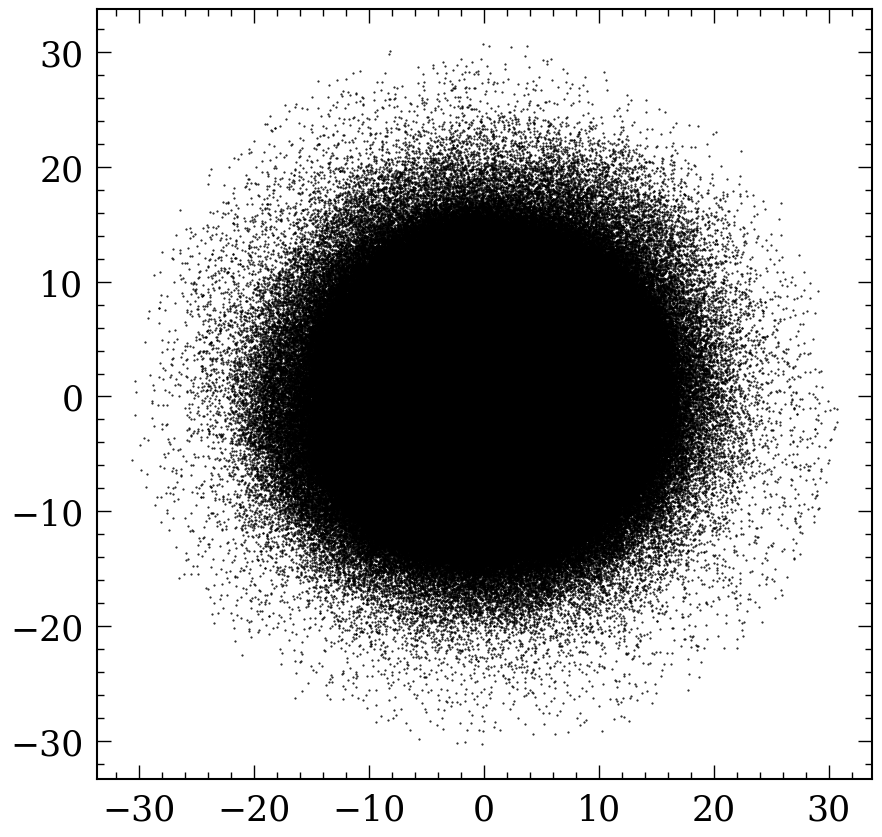

In [277]:
plt.plot(data['x'], data['y'], 'k.', markersize=1)

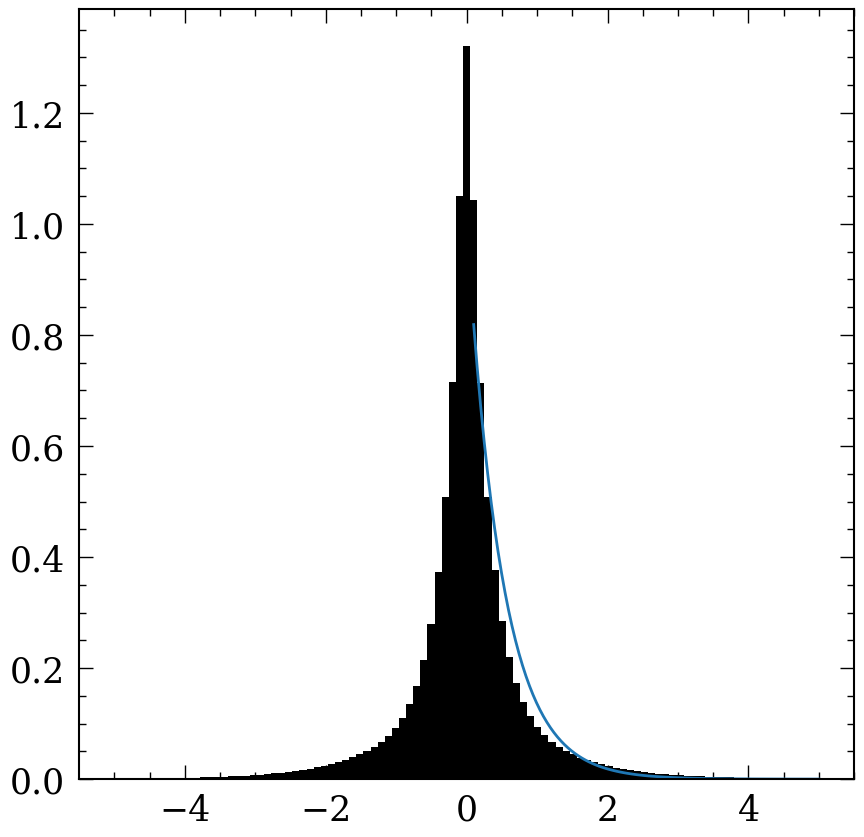

In [278]:
plt.hist(data['z'], bins=np.linspace(-5,5,100), color='k', density=1);
plt.plot(np.linspace(0.1,5,100), np.exp(-np.linspace(0.1,5,100)/0.5))

Text(0, 0.5, '[α/Fe]')

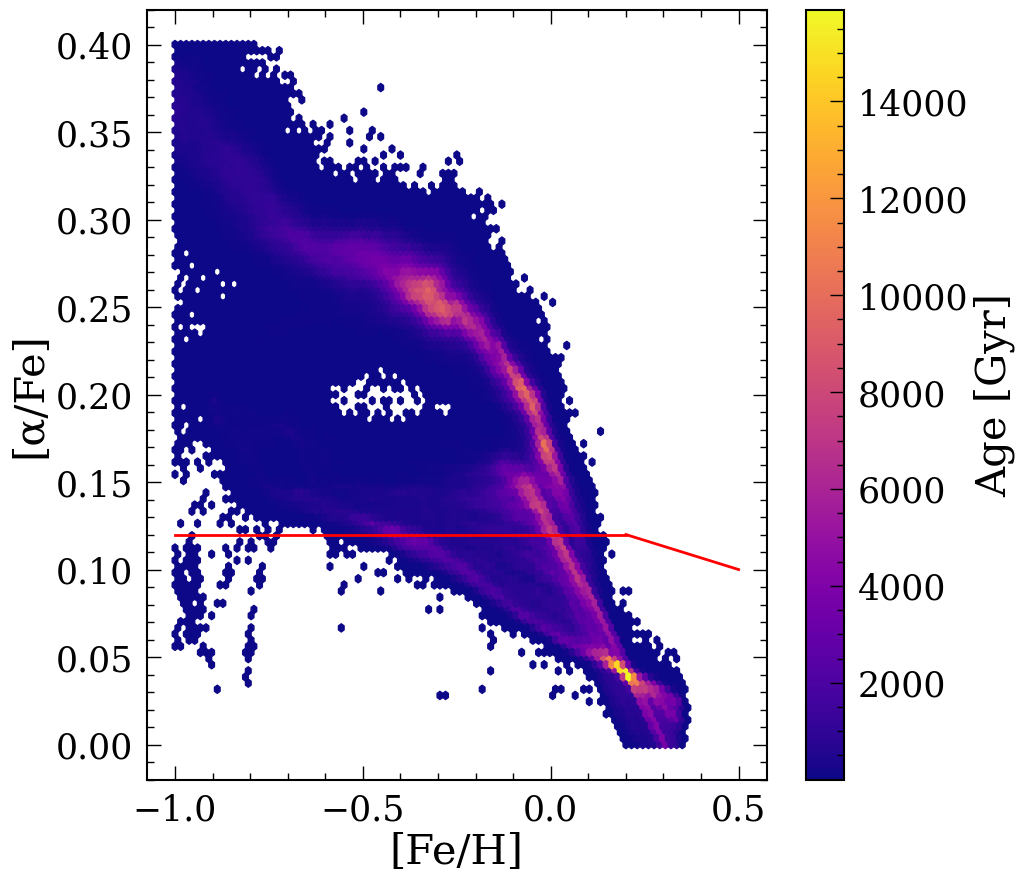

In [227]:
plt.hexbin(data['feh'], data['ofe'], extent=(-1,0.5,0,0.4), cmap='plasma',
          mincnt=1)

plt.plot([-1,0.2], [0.12,0.12], 'r-')
plt.plot([0.2,0.5], [0.12,0.1], 'r-')

def hilow_disk(feh, alpha):
    hi_low = np.zeros(len(feh))
    
    m = feh<0.2
    hi_low[m] = alpha[m]>0.12
    
    p = fitpoints([0.2,0.5], [0.12,0.1])
    hi_low[~m] = alpha[~m]>p(feh[~m])
    
    return hi_low

data['hi_low'] = hilow_disk(data['feh'].values, data['ofe'].values)
#sub_low = data.loc[data['hi_low']==1]
#plt.plot(sub_low['feh'], sub_low['ofe'], 'r.')

cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')



In [228]:
#data[['age','R_bir','feh','R']].to_csv('279e12.csv', index=False)

In [279]:
def coldensity(x,y,binsize=50,extend=[]):
    if len(extend)==0:
        extend=(min(x),max(x),min(y),max(y))
    H, yedges, xedges = np.histogram2d(x, y, 
                                bins=(np.linspace(extend[0],extend[1],binsize),
                                        np.linspace(extend[2],extend[3],binsize)))
    for i in trange(len(yedges)-1):
        m = (x>yedges[i])&(x<yedges[i+1])
        H[i,:] = (H[i,:]/sum(m))/max(H[i,:]/sum(m))
    """for i in trange(len(xedges)-1):
        m = (y>xedges[i])&(y<xedges[i+1])
        H[:,i] = (H[:,i]/sum(m))/max(H[:,i]/sum(m))"""
    
    for i in range(len(H[0,:])):
        for j in range(len(H[:,0])):
            if H[j,i] == 0:
                H[j,i] = np.nan

    return yedges, xedges, H.T


"""plt.figure(figsize=(20,8))
plt.subplot(1,2,1)

yedges, xedges, H = coldensity(data['age_new'], data['rbir_new'],binsize=30,
          extend=(0,13,0,20))

plt.pcolormesh(yedges, xedges, H, vmin=0, vmax=1)
plt.xlabel('Age [Gyr]')
plt.ylabel('$R_{\mathrm{bir}}$')
plt.colorbar(label='# of stars')


plt.subplot(1,2,2)"""

"""plt.figure(figsize=(10,8))
m = (data['R']>7)&(data['R']<10)
yedges, xedges, H = coldensity(data['age_new'][m], data['rbir_new'][m],binsize=30,
          extend=(0,13,0,20))

plt.pcolormesh(yedges, xedges, H, vmin=0, vmax=1)
plt.xlabel('Age [Gyr]')
plt.ylabel('$R_{\mathrm{bir}}$')
plt.colorbar(label='# of stars')
plt.tight_layout()

plt.savefig('Rb_279e12_norm.png')
plt.savefig('Rb_279e12_norm')"""

"plt.figure(figsize=(10,8))\nm = (data['R']>7)&(data['R']<10)\nyedges, xedges, H = coldensity(data['age_new'][m], data['rbir_new'][m],binsize=30,\n          extend=(0,13,0,20))\n\nplt.pcolormesh(yedges, xedges, H, vmin=0, vmax=1)\nplt.xlabel('Age [Gyr]')\nplt.ylabel('$R_{\\mathrm{bir}}$')\nplt.colorbar(label='# of stars')\nplt.tight_layout()\n\nplt.savefig('Rb_279e12_norm.png')\nplt.savefig('Rb_279e12_norm')"

In [230]:
"""plt.hexbin(data['age_new'][m], data['feh'][m],
          extent=(0,14,-1,0.5))"""

"""yedges, xedges, H = coldensity(data['age_new'][m], data['feh'][m],binsize=30,
          extend=(0,14,-1,0.5))

plt.pcolormesh(yedges, xedges, H, vmin=0, vmax=1)"""


"yedges, xedges, H = coldensity(data['age_new'][m], data['feh'][m],binsize=30,\n          extend=(0,14,-1,0.5))\n\nplt.pcolormesh(yedges, xedges, H, vmin=0, vmax=1)"

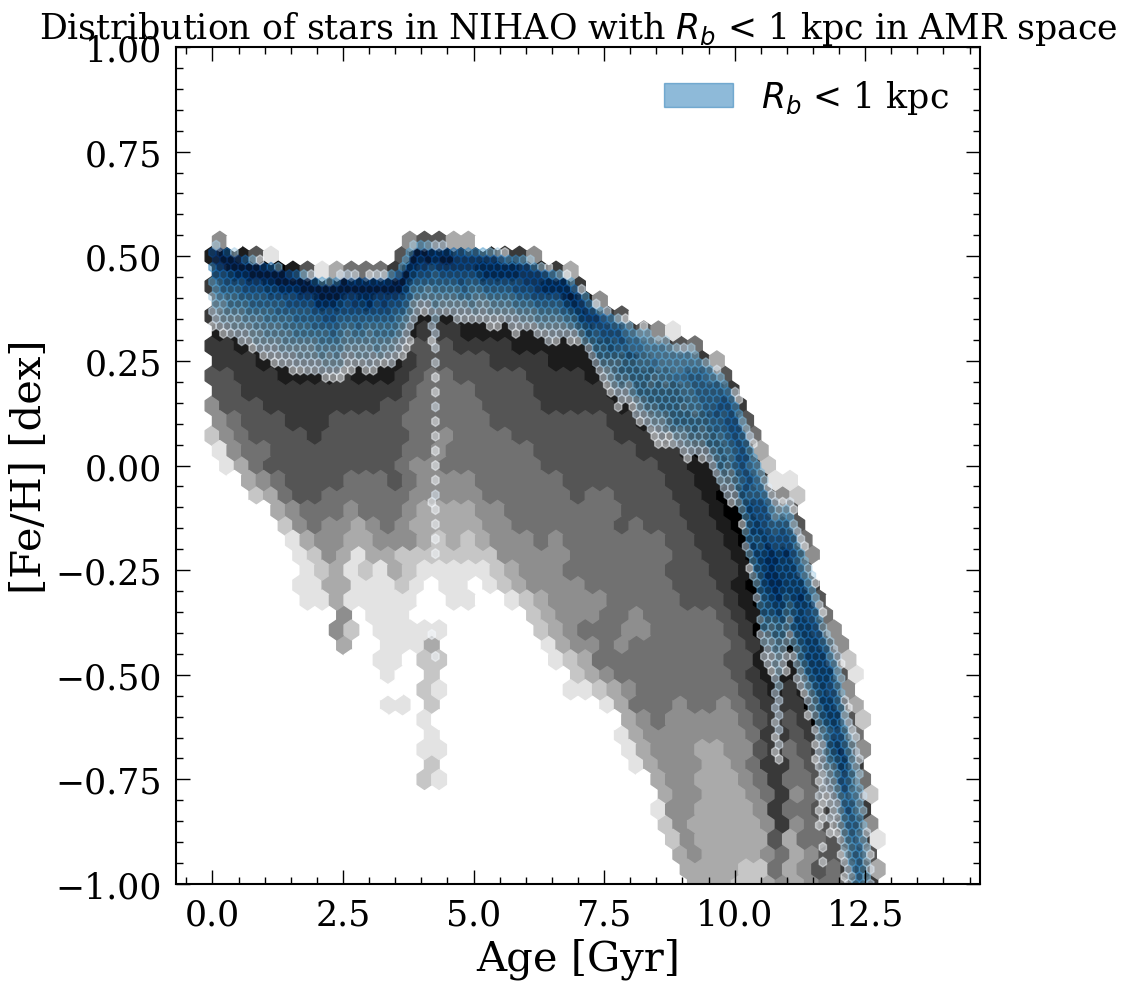

In [280]:
"""plt.figure()
plt.hexbin(data['age'], data['feh'], 
          extent=(0,14,-1,1),mincnt=1)"""


plt.figure()
m = (data['R']<4)
plt.hexbin(data['age'][m], data['feh'][m], 
          extent=(0,14,-1,1),mincnt=1,
           gridsize=50,cmap=plt.get_cmap('binary',10),
          bins='log')

m = (data['R_bir']<1)
plt.hexbin(data['age'][m], data['feh'][m], 
           cmap=plt.get_cmap('Blues',10), mincnt=50,
          extent=(0,14,-1,1),bins='log',label='$R_b$ < 1 kpc',
          alpha=0.5)
plt.ylim([-1,1])
plt.legend()
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] [dex]')
plt.title('Distribution of stars in NIHAO with $R_b$ < 1 kpc in AMR space', fontsize=25)
plt.tight_layout()
#plt.savefig('AddFig/highres/NIHAO_rb1')
#plt.savefig('AddFig/NIHAO_rb1.png')



In [282]:
m = (data['R']<4)

allages = data['age'].values
allfehs = data['feh'].values
allofes = data['ofe'].values

data['age_new'] = [np.random.normal(i, 0.32, 1) for i in allages]
data['feh_new'] = [np.random.normal(i, 0.03, 1) for i in allfehs]
data['ofe_new'] = [np.random.normal(i, 0.03, 1) for i in allofes]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.59it/s]


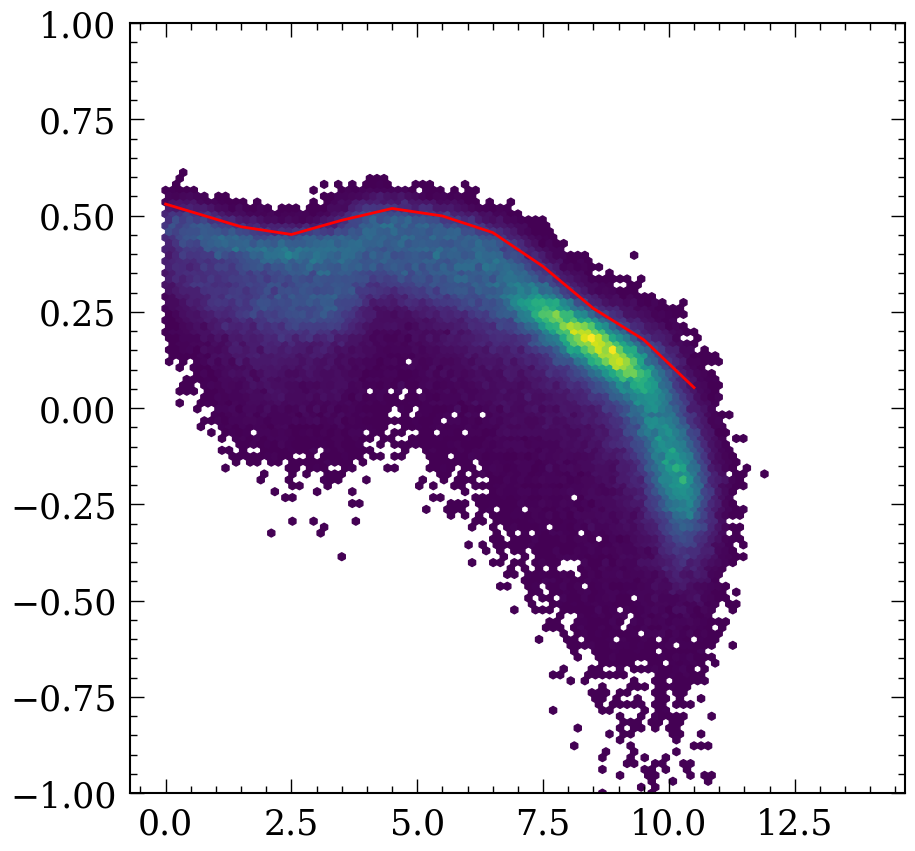

In [292]:
data = data.loc[data['feh']>-1]
#data = data.loc[data['feh']<0.5]
data_in = (data[(data['R']<4)].reset_index(drop=True))[['age_new','feh_new']].reset_index(drop=True)
agebin = np.linspace(0,11,12)
feh0 = np.zeros(len(agebin))

for i in trange(len(agebin)-1):
    m2 = (data_in['age_new']>agebin[i])&(data_in['age_new']<agebin[i+1])
    feh0[i+1] = np.percentile(data_in['feh_new'][m2], 95)

plt.hexbin(data_in['age_new'], data_in['feh_new'], extent=(0,14,-1,0.75),
          mincnt=1)

#feh0[np.append([0], agebin[1:]/2+agebin[:-1]/2)>2] = feh0[np.append([0], agebin[1:]/2+agebin[:-1]/2)>2]+0.1
#feh0 = feh0+0.1
feh0[0] = 0.53
#feh0[0] = 0.35

#feh0

plt.ylim([-1,1])
plt.plot(np.append([0], agebin[1:]/2+agebin[:-1]/2), feh0, 'r-')


In [293]:
def getRb(age, feh, func_m, func_b, fehoffset=0):
    """slopefeh = pd.read_csv('g2.79e12_fehscatter_simdata_inf.csv')
    
    func_m = interp1d(slopefeh['age'].values, 
                      slopefeh['sloperb_inf'].values,
                     kind='linear')
    
    func_m = interp1d(slopefeh['age'].values, 
                      slopefeh['slopes_rbir'].values,
                     kind='linear')
    
    func_b = interp1d(np.append([0], agebin[1:]/2+agebin[:-1]/2), feh0,
                     kind='linear')"""
    
    Rb = np.zeros(len(age))
    for i in trange(len(age)):
        try:
            m = func_m(age[i])
            b = func_b(age[i])
            Rb[i] = (feh[i]-b)/m
        except:
            Rb[i] = np.nan
    return Rb


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


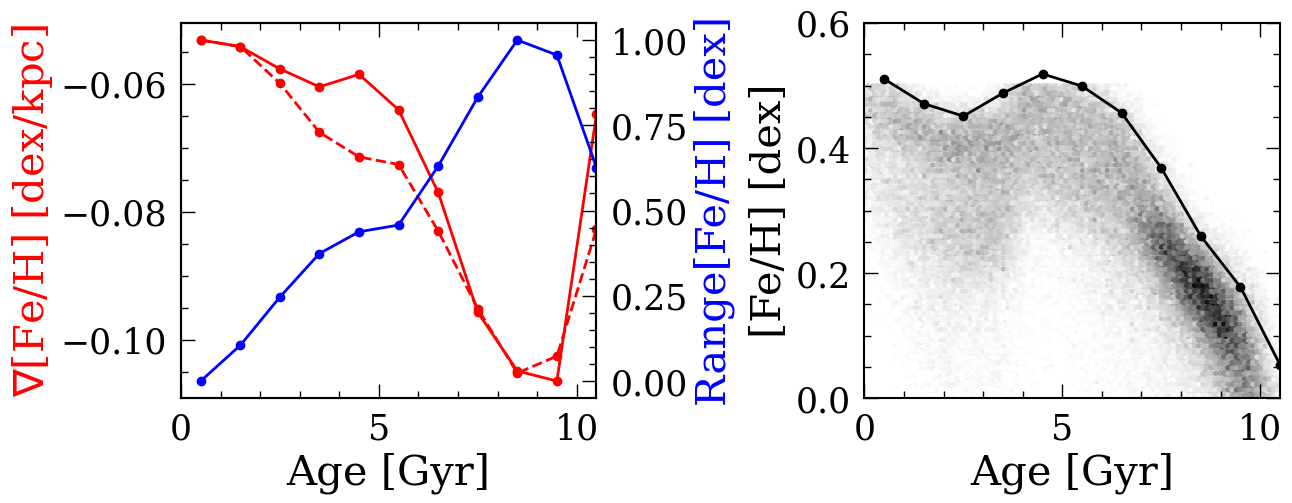

In [296]:
#slopefeh = pd.read_csv('g7.55e11_fehscatter_simdata.csv')
slopefeh = pd.read_csv('g2.79e12_fehscatter_simdata.csv')
#disktime = 6.7
disktime = 10.5

slopefeh = slopefeh.loc[slopefeh['age']<=disktime+0.8]
x = slopefeh['slopes_rbir']

msel = (slopefeh['age']<2)

slopefeh = slopefeh.dropna(subset=['fehscatter'])
slopefeh['fehscatter'] = (slopefeh['fehscatter']-min(slopefeh['fehscatter']))/(max(slopefeh['fehscatter'])-min(slopefeh['fehscatter']))
p = fitpoints(slopefeh['fehscatter'], x)
multfac = 1.05
#realsope = (slopefeh['slopes_rbir'].iloc[0])
#slopefeh['sloperb_inf'] = (p(slopefeh['fehscatter']))*multfac-(p(slopefeh['fehscatter'].iloc[0]))*multfac+realsope
slopefeh['sloperb_inf'] = p(slopefeh['fehscatter'])*multfac
slopefeh['sloperb_inf'][msel] = slopefeh['slopes_rbir'][msel]

func_m_true = interp1d(slopefeh['age'].values, 
                      slopefeh['slopes_rbir'].values,
                     kind='linear')

func_m = interp1d(slopefeh['age'].values, 
                      slopefeh['sloperb_inf'].values,
                     kind='linear')

func_b = interp1d(np.append([0], agebin[1:]/2+agebin[:-1]/2), feh0,
                     kind='linear')


plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(np.linspace(0.5,disktime,len(slopefeh['fehscatter'])), func_m(np.linspace(0.5,disktime,len(slopefeh['fehscatter']))), 'r--o',
        label='Inferred')
plt.plot(np.linspace(0.5,disktime,len(slopefeh['fehscatter'])), func_m_true(np.linspace(0.5,disktime,len(slopefeh['fehscatter']))), 'r-o',
        label='True')
plt.xlabel('Age [Gyr]')
plt.ylabel('$\\nabla$[Fe/H] [dex/kpc]', color='red')
plt.xlim([0,disktime])
plt.twinx()
plt.plot(np.linspace(0.5,disktime,len(slopefeh['fehscatter'])), slopefeh['fehscatter'], 'b-o',
        label='True')
plt.ylabel('Range[Fe/H] [dex]', color='blue')



plt.subplot(1,2,2)
plt.hexbin(data_in['age_new'], data_in['feh_new'], extent=(0,disktime,0,0.5),
          mincnt=1, cmap='binary')
plt.plot(np.linspace(0.5,disktime,11), func_b(np.linspace(0.5,disktime,11)), 'k-o')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] [dex]')
plt.legend()
plt.tight_layout()

plt.xlim([0,disktime])
plt.ylim([0,0.6])

plt.savefig('AddFig/g279e12_slopefeh.png',bbox_inches='tight')
plt.savefig('AddFig/highres/g279e12_slopefeh',bbox_inches='tight')
#plt.savefig('AddFig/g755e11_slopefeh.png',bbox_inches='tight')
#plt.savefig('AddFig/highres/g755e11_slopefeh',bbox_inches='tight')




In [297]:
data['vr'], data['vphi'], data['ecc'] = calcvel(data.vx_today, data.vy_today, 
                                                data.x, data.y, 240)

data['vr_b'], data['vphi_b'], data['ecc_b'] = calcvel(data.vx_birth, data.vy_birth, 
                                                data.x_birth, data.y_birth, 240)
data['Rg_b'] = data['R_bir']*data['vphi_b']/240

In [298]:
data = data.loc[(data['age']<disktime)&(data['ecc']<0.2)]
data= data.loc[(~((data['feh']<-0.5)&(data['age']<6)))]
data = data.reset_index(drop=True)
#data['Rb_inf'] = getRb(data['age'].values, data['feh'].values, func_m, func_b)
#data['Rb_inf'] = getRb(data['age'].values, data['feh'].values, func_m_true, func_b)

In [299]:
data['Rb_inf_new'] = getRb(data['age_new'].values, data['feh_new'].values, func_m, func_b)

100%|███████████████████████████████████████████████████████████████████████████████| 529214/529214 [00:07<00:00, 69973.22it/s]


In [300]:
"""m = (data['age']>6)&(data['age']<7)
plt.hexbin(data['Rb_inf'][m], data['feh'][m])"""

"m = (data['age']>6)&(data['age']<7)\nplt.hexbin(data['Rb_inf'][m], data['feh'][m])"

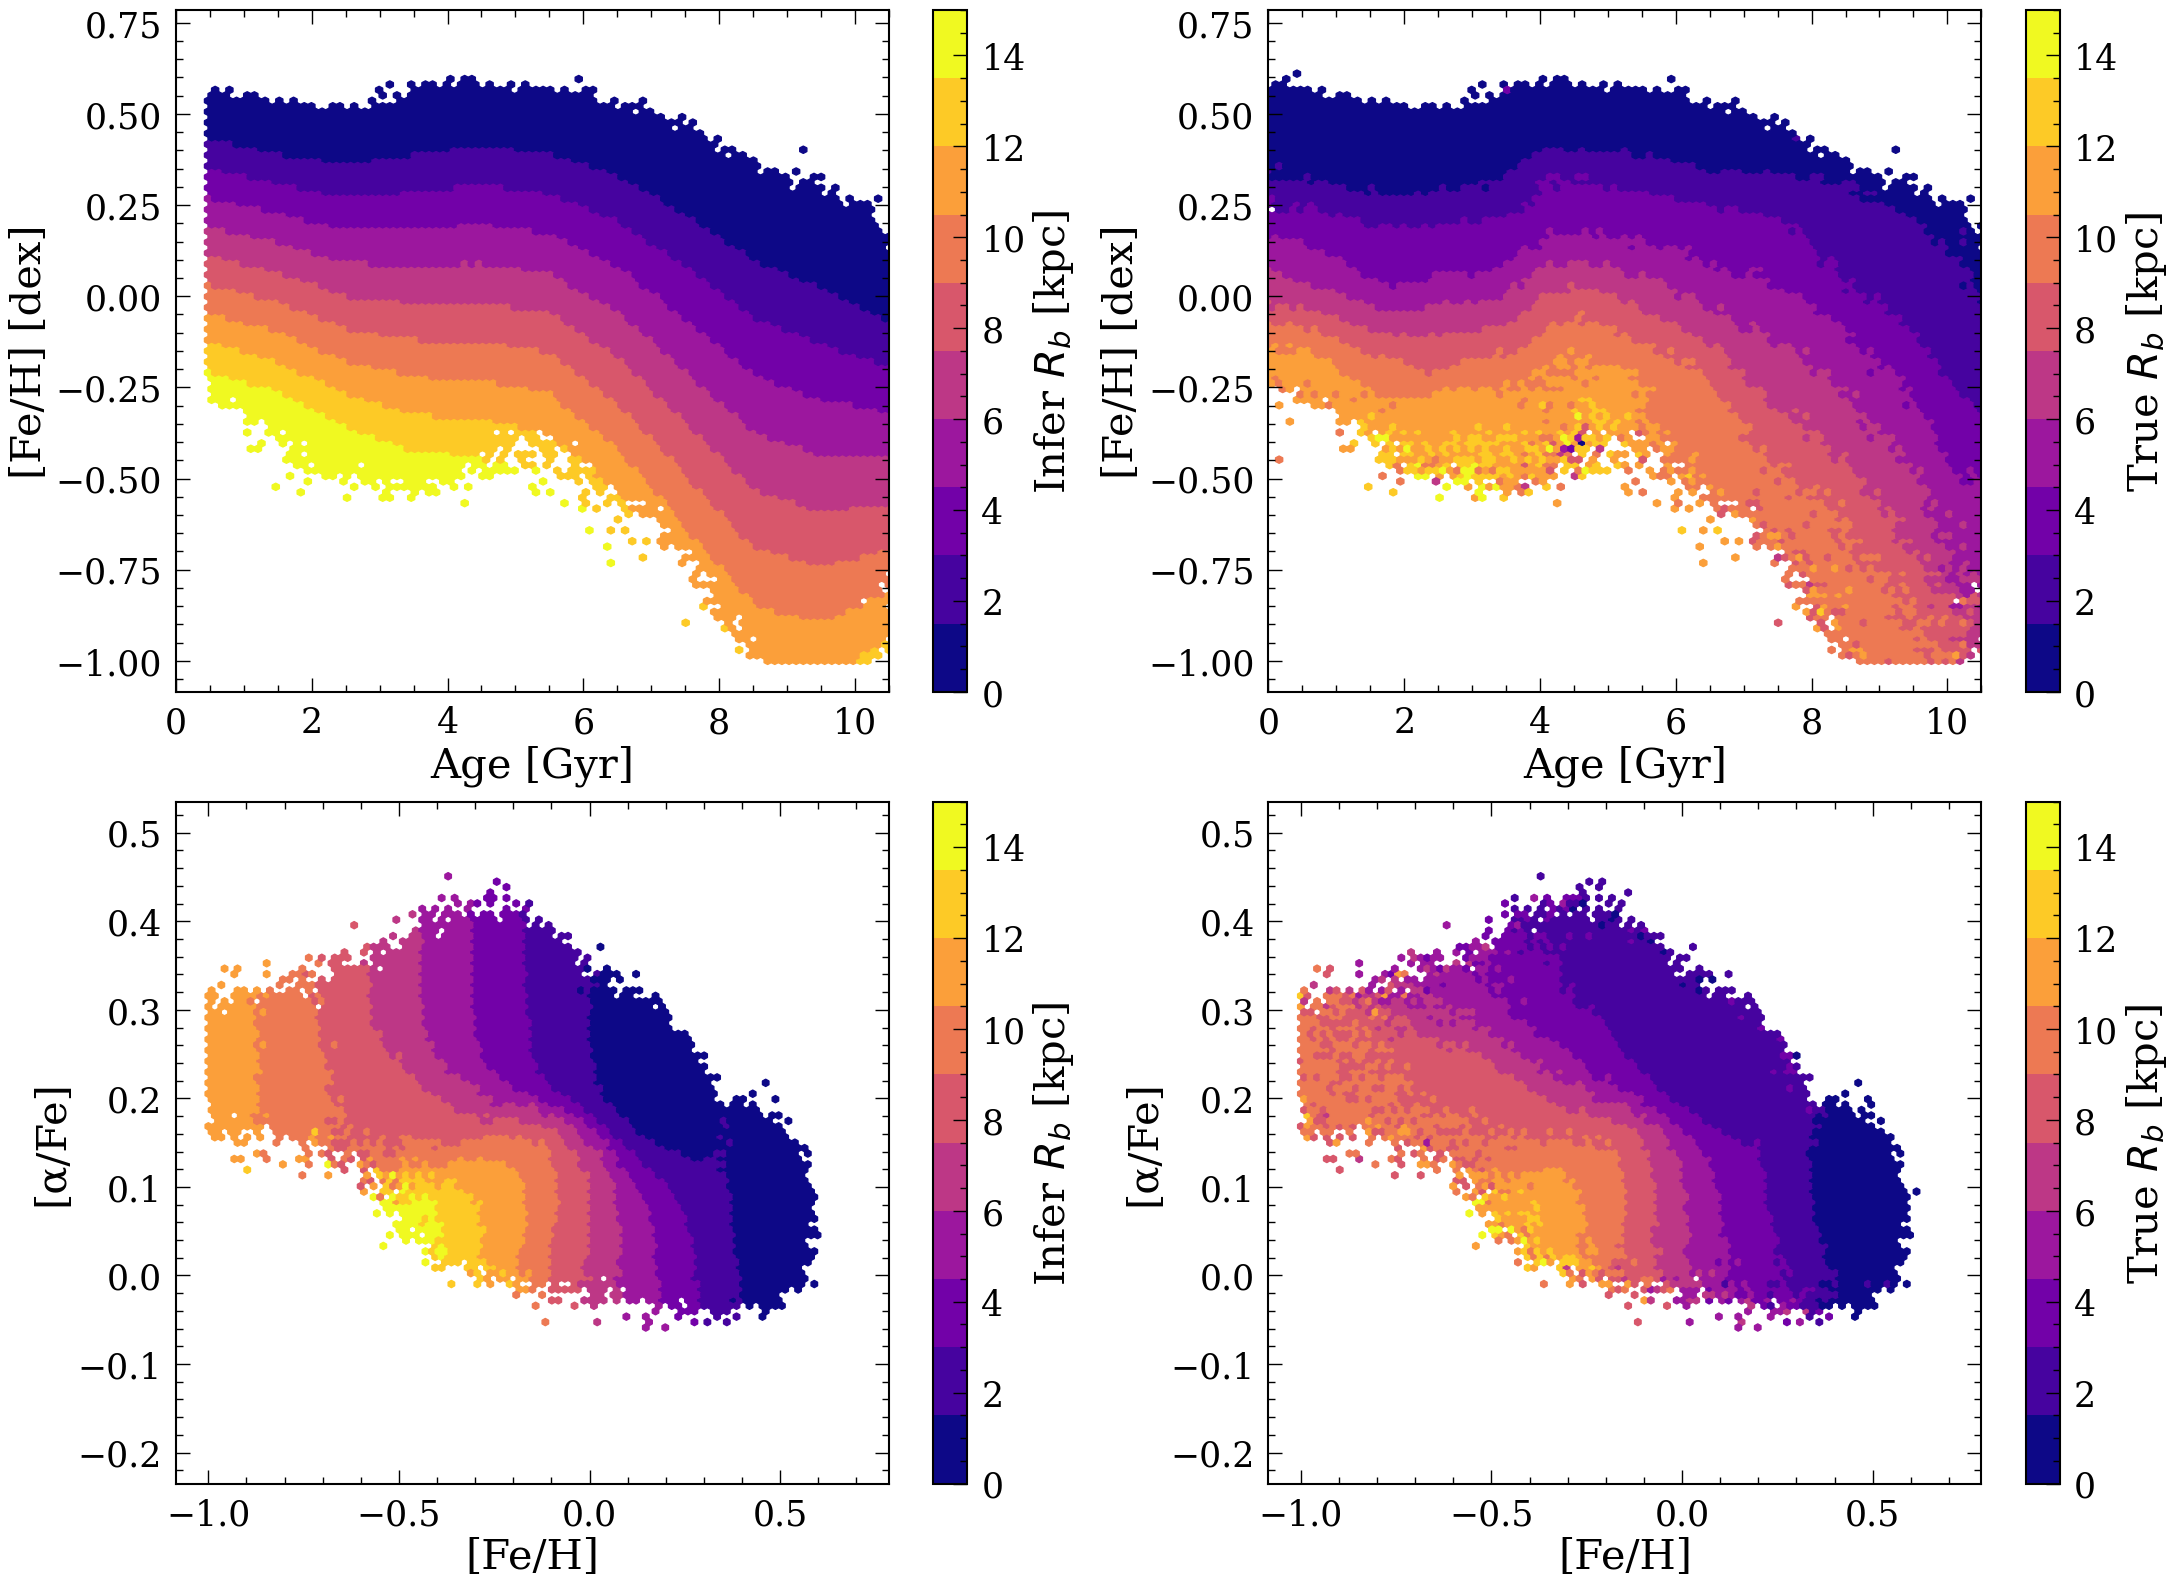

In [301]:
plt.figure(figsize=(22,16))
plt.subplot(2,2,1)
plt.hexbin(data['age_new'],data['feh_new'],C=data['Rb_inf_new'],
          cmap=plt.get_cmap('plasma',10),vmin=0,vmax=15,extent=(0,disktime,-1,0.7))
plt.colorbar(label='Infer $R_b$ [kpc]')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] [dex]')
plt.xlim([0,disktime])

plt.subplot(2,2,2)
plt.hexbin(data['age_new'],data['feh_new'],C=data['R_bir'],
          cmap=plt.get_cmap('plasma',10),vmin=0,vmax=15,extent=(0,disktime,-1,0.7))
plt.colorbar(label='True $R_b$ [kpc]')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] [dex]')
plt.xlim([0,disktime])

plt.subplot(2,2,3)
plt.hexbin(data['feh_new'], data['ofe_new'],C=data['Rb_inf_new'],
          cmap=plt.get_cmap('plasma',10),vmin=0,vmax=15,extent=(-1,0.7,-0.2,0.5))
plt.colorbar(label='Infer $R_b$ [kpc]')
plt.ylabel('[α/Fe]')
plt.xlabel('[Fe/H]')
#plt.xlim([0,disktime])

plt.subplot(2,2,4)
plt.hexbin(data['feh_new'], data['ofe_new'],C=data['R_bir'],
          cmap=plt.get_cmap('plasma',10),vmin=0,vmax=15,extent=(-1,0.7,-0.2,0.5))
plt.colorbar(label='True $R_b$ [kpc]')
plt.ylabel('[α/Fe]')
plt.xlabel('[Fe/H]')
#plt.xlim([0,0.5])

plt.tight_layout()

plt.savefig('AddFig/g279e12_AMR.png',bbox_inches='tight')
plt.savefig('AddFig/highres/g279e12_AMR',bbox_inches='tight')

#plt.savefig('AddFig/g755e11_AMR.png',bbox_inches='tight')
#plt.savefig('AddFig/highres/g755e11_AMR',bbox_inches='tight')

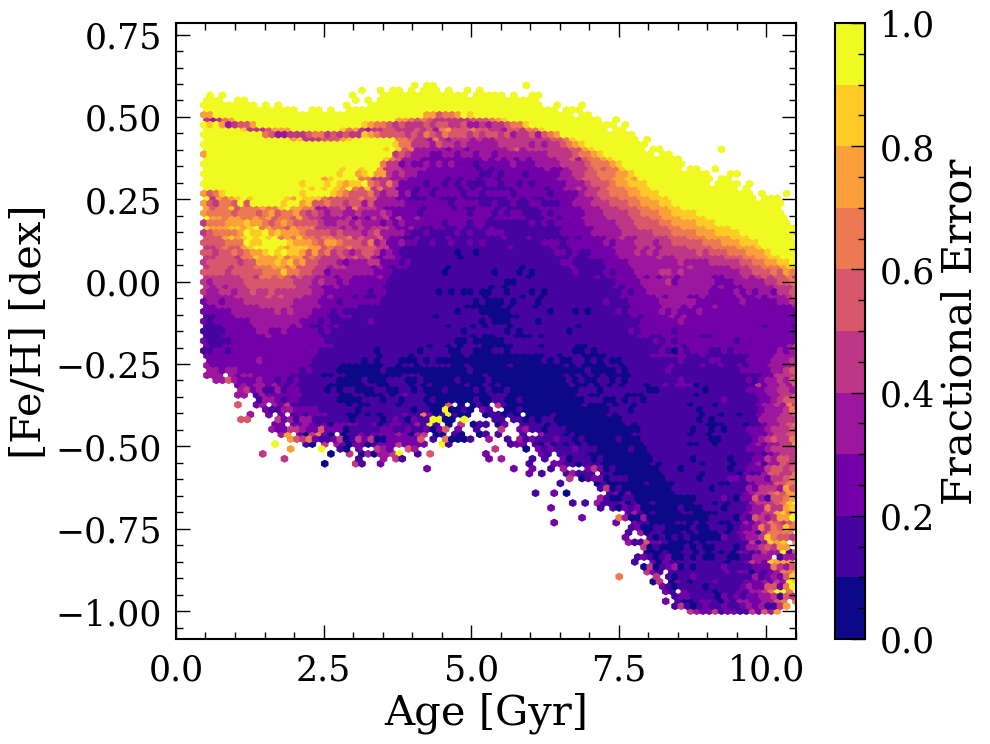

In [302]:
plt.figure(figsize=(10,8))
plt.hexbin(data['age_new'],data['feh_new'],C=abs(data['Rb_inf_new']-data['R_bir'])/data['R_bir'],
          cmap=plt.get_cmap('plasma',10),vmin=0,vmax=1,extent=(0,disktime,-1,0.7),
          reduce_C_function=np.median)
plt.colorbar(label='Fractional Error')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] [dex]')
plt.xlim([0,disktime])

plt.savefig('AddFig/g279e12_AMR_percerr.png',bbox_inches='tight')
plt.savefig('AddFig/highres/g279e12_AMR_percerr',bbox_inches='tight')

In [158]:
"""plt.hexbin(data['age_new'],data['feh_new'],
          cmap=plt.get_cmap('plasma',10),extent=(0,disktime,-1,0.7),
          mincnt=1)
plt.colorbar(label='density')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] [dex]')
plt.xlim([0,disktime])"""

"plt.hexbin(data['age_new'],data['feh_new'],\n          cmap=plt.get_cmap('plasma',10),extent=(0,disktime,-1,0.7),\n          mincnt=1)\nplt.colorbar(label='density')\nplt.xlabel('Age [Gyr]')\nplt.ylabel('[Fe/H] [dex]')\nplt.xlim([0,disktime])"

In [159]:
"""plt.figure(figsize=(10,8))
#m_cut = (data['age']<disktime)
m_cut = (data['age']>4)&(data['age']<5)
plt.hexbin(data['R_bir'][m_cut], data['feh'][m_cut], 
           cmap=plt.get_cmap('binary',10),
         mincnt=1, extent=(0,30,-1,0.5), bins='log')
plt.ylabel('[Fe/H]')
plt.xlabel('True $R_b$ [kpc]')
plt.xlim([0,30])
plt.ylim([-1,0.5])
#plt.colorbar(label='Age [Gyr]')
plt.tight_layout()


#m_cut = (data['age']<disktime)
plt.hexbin(data['Rb_inf_new'][m_cut], data['feh'][m_cut], 
           cmap=plt.get_cmap('Blues',10),vmin=0,alpha=0.5,
         mincnt=1, extent=(0,30,-1,0.5))
plt.ylabel('[Fe/H]')
plt.xlabel('Predicted $R_b$ [kpc]')
plt.xlim([0,30])
plt.ylim([-1,0.5])
#plt.colorbar(label='Age [Gyr]')
plt.tight_layout()

"""

"plt.figure(figsize=(10,8))\n#m_cut = (data['age']<disktime)\nm_cut = (data['age']>4)&(data['age']<5)\nplt.hexbin(data['R_bir'][m_cut], data['feh'][m_cut], \n           cmap=plt.get_cmap('binary',10),\n         mincnt=1, extent=(0,30,-1,0.5), bins='log')\nplt.ylabel('[Fe/H]')\nplt.xlabel('True $R_b$ [kpc]')\nplt.xlim([0,30])\nplt.ylim([-1,0.5])\n#plt.colorbar(label='Age [Gyr]')\nplt.tight_layout()\n\n\n#m_cut = (data['age']<disktime)\nplt.hexbin(data['Rb_inf_new'][m_cut], data['feh'][m_cut], \n           cmap=plt.get_cmap('Blues',10),vmin=0,alpha=0.5,\n         mincnt=1, extent=(0,30,-1,0.5))\nplt.ylabel('[Fe/H]')\nplt.xlabel('Predicted $R_b$ [kpc]')\nplt.xlim([0,30])\nplt.ylim([-1,0.5])\n#plt.colorbar(label='Age [Gyr]')\nplt.tight_layout()\n\n"

In [160]:
"""plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hexbin(data['R_bir'], data['Rb_inf'], cmap='binary',
         mincnt=1, extent=(0,20,0,20), bins='log',
          label='Bias:%.2f [kpc]\nScatter:%.2f [kpc]'%(np.mean(data['R_bir']-data['Rb_inf']), np.std(data['R_bir']-data['Rb_inf'])))
plt.plot([0,20],[0,20],'r-')
plt.xlabel('True $R_b$ [kpc]')
plt.ylabel('Predicted $R_b$ [kpc]')
plt.xlim([0,20])
plt.ylim([0,20])
plt.colorbar(label='Density')

plt.legend()

plt.subplot(1,2,2)
#m_cut = (data['age']<disktime)
m_cut = (data['age']<disktime)
plt.hexbin(data['R_bir'][m_cut], data['Rb_inf'][m_cut], C=data['age'][m_cut],
           cmap=plt.get_cmap('plasma',10),vmin=0,vmax=disktime,
         mincnt=1, extent=(0,20,0,20))
plt.plot([0,20],[0,20],'r-')
plt.xlabel('True $R_b$ [kpc]')
plt.ylabel('Predicted $R_b$ [kpc]')
plt.xlim([0,20])
plt.ylim([0,20])
plt.colorbar(label='Age [Gyr]')
plt.tight_layout()

plt.savefig('AddFig/g279e12_test_1.png',bbox_inches='tight')
plt.savefig('AddFig/highres/g279e12_test_1',bbox_inches='tight')"""

"plt.figure(figsize=(20,8))\nplt.subplot(1,2,1)\nplt.hexbin(data['R_bir'], data['Rb_inf'], cmap='binary',\n         mincnt=1, extent=(0,20,0,20), bins='log',\n          label='Bias:%.2f [kpc]\nScatter:%.2f [kpc]'%(np.mean(data['R_bir']-data['Rb_inf']), np.std(data['R_bir']-data['Rb_inf'])))\nplt.plot([0,20],[0,20],'r-')\nplt.xlabel('True $R_b$ [kpc]')\nplt.ylabel('Predicted $R_b$ [kpc]')\nplt.xlim([0,20])\nplt.ylim([0,20])\nplt.colorbar(label='Density')\n\nplt.legend()\n\nplt.subplot(1,2,2)\n#m_cut = (data['age']<disktime)\nm_cut = (data['age']<disktime)\nplt.hexbin(data['R_bir'][m_cut], data['Rb_inf'][m_cut], C=data['age'][m_cut],\n           cmap=plt.get_cmap('plasma',10),vmin=0,vmax=disktime,\n         mincnt=1, extent=(0,20,0,20))\nplt.plot([0,20],[0,20],'r-')\nplt.xlabel('True $R_b$ [kpc]')\nplt.ylabel('Predicted $R_b$ [kpc]')\nplt.xlim([0,20])\nplt.ylim([0,20])\nplt.colorbar(label='Age [Gyr]')\nplt.tight_layout()\n\nplt.savefig('AddFig/g279e12_test_1.png',bbox_inches='tight')\npl

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


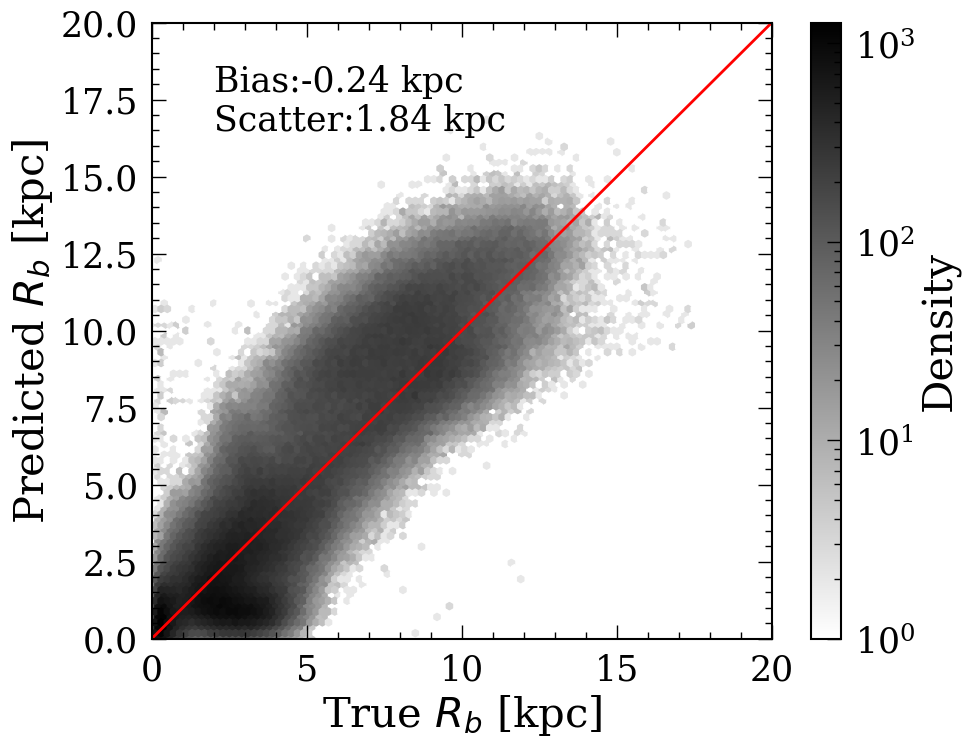

In [303]:
#plt.figure(figsize=(20,8))
#plt.subplot(1,2,1)
plt.figure(figsize=(10,8))
m_cut = (data['age']<disktime)
plt.hexbin(data['R_bir'][m_cut], data['Rb_inf_new'][m_cut], cmap='binary',
         mincnt=1, extent=(0,20,0,20), bins='log')
plt.plot([0,20],[0,20],'r-')
plt.xlabel('True $R_b$ [kpc]')
plt.ylabel('Predicted $R_b$ [kpc]')
plt.xlim([0,20])
plt.ylim([0,20])
plt.colorbar(label='Density')
plt.text(2,16.5,'Bias:%.2f kpc\nScatter:%.2f kpc'%(np.mean(data['R_bir'][m_cut]-data['Rb_inf_new'][m_cut]), np.std(data['R_bir'][m_cut]-data['Rb_inf_new'][m_cut])), fontsize=25)

plt.legend(loc=2)

"""plt.subplot(1,2,2)
m_cut = (data['age']<disktime)
plt.hexbin(data['R_bir'][m_cut], data['Rb_inf_new'][m_cut], C=data['age'][m_cut],
           cmap=plt.get_cmap('plasma',10),vmin=0,vmax=disktime,
         mincnt=1, extent=(0,20,0,20))
plt.plot([0,20],[0,20],'r-')
plt.xlabel('True $R_b$ [kpc]')
plt.ylabel('Predicted $R_b$ [kpc]')
plt.xlim([0,20])
plt.ylim([0,20])
plt.colorbar(label='Age [Gyr]')
plt.tight_layout()"""

#plt.savefig('AddFig/g755e11_test_1.png',bbox_inches='tight')
#plt.savefig('AddFig/highres/g755e11_test_1',bbox_inches='tight')

plt.savefig('AddFig/g279e12_test_1.png',bbox_inches='tight')
plt.savefig('AddFig/highres/g279e12_test_1',bbox_inches='tight')

In [810]:
np.mean(abs(data['R_bir'][m_cut]-data['Rb_inf_new'][m_cut])/(data['R_bir'][m_cut]))

0.9911767728073789

100%|██████████| 39/39 [00:00<00:00, 502.83it/s]


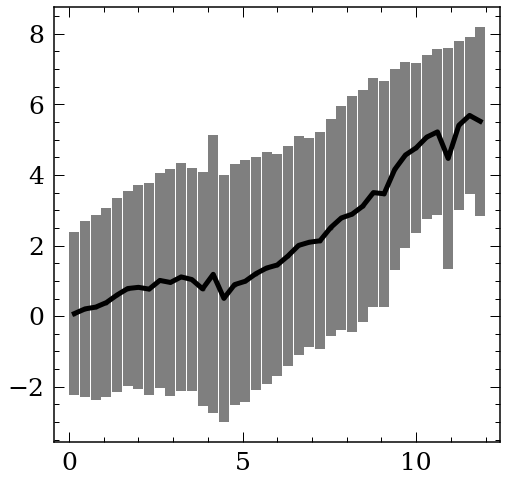

In [15]:
agebincalc_rm = np.linspace(0,12,40)
sub_tryRb_sub = data
sub_tryRb_sub = sub_tryRb_sub.loc[sub_tryRb_sub['rbir_new']<20]
sub_tryRb_sub = sub_tryRb_sub.loc[sub_tryRb_sub['feh']>-1]
sub_tryRb_sub = sub_tryRb_sub.loc[abs(sub_tryRb_sub['R']-8.2)<0.5]

mean_dr = np.zeros(len(agebincalc_rm)-1)
std_dr = np.zeros(len(agebincalc_rm)-1)

mean_blr = np.zeros(len(agebincalc_rm)-1)
std_blr = np.zeros(len(agebincalc_rm)-1)

for i in trange(len(agebincalc_rm)-1):
    sub_tryRb_sing = sub_tryRb_sub.loc[(sub_tryRb_sub['age']>agebincalc_rm[i])&(sub_tryRb_sub['age']<agebincalc_rm[i+1])]

    sub_tryRb_sing = sub_tryRb_sing.dropna(subset=['rbir_new','R'])
    
    if len(sub_tryRb_sing)<30:
        mean_dr[i] = np.nan
        std_dr[i] = np.nan
        
        mean_blr[i] = np.nan
        std_blr[i] = np.nan
        continue
    
    mean_dr[i] = np.mean(sub_tryRb_sing['R']-sub_tryRb_sing['rbir_new'])
    std_dr[i] = np.std(sub_tryRb_sing['R']-sub_tryRb_sing['rbir_new'])

        
plt.figure(figsize=(8,8))

plt.errorbar((agebincalc_rm[1:]+agebincalc_rm[:-1])/2, mean_dr,
             yerr=std_dr, fmt='.',  color='k', alpha=0.5,
            linewidth=10)
plt.plot((agebincalc_rm[1:]+agebincalc_rm[:-1])/2, mean_dr,'-',
         color='k', linewidth=5, label='Migration')



## + err

In [248]:
import warnings
warnings.filterwarnings('ignore')

data['age_new'] = [np.random.normal(i, 0.5) for i in data['age']]
data['rbir_new'] = [np.random.normal(i, 1.12+1) for i in data['R_bir']]
data['R_new'] = [np.random.normal(i, 0.31) for i in data['R']]


In [262]:
checkdist = 5
def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),
                feherr=[],xlims=[0,25],checkplt=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
            
        if (agebin[i]==4)&(simNo=='2_79e12'):
            #xlims=[0,5]
            m = ~((r_sing<1)&(feh_sing<0.35))
            m = m&(~((r_sing<5)&(feh_sing<0)))
            r_sing, feh_sing = r_sing[m], feh_sing[m]
            
        if (agebin[i]==5)&(simNo=='2_79e12'):
            xlims=[0,15]
            
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        #feh_sing_fit, r_sing_fit = zip(*sorted(zip(feh_sing[m2], r_sing[m2])))
        #r_sing_fit, feh_sing_fit = np.array(r_sing_fit), np.array(feh_sing_fit)
        #feh_sing_fit, r_sing_fit = movingMed_time(feh_sing_fit, r_sing_fit, 0.1, 0.01)
        #r_sing_fit, feh_sing_fit = np.array(r_sing_fit), np.array(feh_sing_fit)
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        #p = fitpoints(r_sing_fit, feh_sing_fit) 
        slopes[i] = p[1]
        
        m3 = abs(r_sing[m2]-checkdist)<0.2
        if sum(m3)<50:
            fehscatter[i] = np.nan
        else:
            fehscatter[i] = np.std(feh_sing[m2][m3]-p(r_sing[m2][m3]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        if checkplt:
            plt.figure(figsize=(8,8))
            plt.hexbin(r_sing[m2], feh_sing[m2],extent=(0,15,-0.75,0.5), bins='log',
                      cmap='binary')
            plt.plot(r_sing[m2], p(r_sing[m2]), 'k-',
                    label='%.2f Rb+%.2f'%(p[1],p[0]))
            #plt.plot([0,15], [np.percentile(feh_sing[m2],95),np.percentile(feh_sing[m2],95)],'b-')
            #plt.plot([0,15], [np.percentile(feh_sing[m2],5),np.percentile(feh_sing[m2],5)],'b-')
            #plt.plot([np.percentile(r_sing[m2],95),np.percentile(r_sing[m2],95)], [-3,0.5],'b-')
            #plt.plot([np.percentile(r_sing[m2],5),np.percentile(r_sing[m2],5)], [-3,0.5],'b-')
            plt.xlim([0,15])
            plt.ylim([-0.75,0.5])
            plt.xlabel('Rb [kpc]')
            plt.ylabel('[Fe/H]')
            plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                     fontsize=25)
            plt.legend()
            plt.savefig(str(len(agebin)-1-i)+'.png')

    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter

In [250]:
#agebin = np.linspace(2,15,10)

In [251]:
def calcvel(vx, vy, x, y, v0):
    R = np.sqrt(x**2+y**2)
    vr = (x * vx + y * vy)/R
    vphi = (x * vy - y * vx)/R
    ecc = np.sqrt(vr**2 + 2.*(vphi-v0)**2)/(np.sqrt(2.)*v0)
    
    return vr, vphi, ecc

In [252]:
data['vr'], data['vphi'], data['ecc'] = calcvel(data.vx_today, data.vy_today, 
                                                data.x, data.y, 240)

data['vr_b'], data['vphi_b'], data['ecc_b'] = calcvel(data.vx_birth, data.vy_birth, 
                                                data.x_birth, data.y_birth, 240)
data['Rg_b'] = data['R_bir']*data['vphi_b']/240

In [267]:


def monoage_line_range(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],plotlegend=True,rrange_feh=[7,10]):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        fehscatter[i] = np.percentile(feh_sing[m2],95)-np.percentile(feh_sing[m2],5)
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter


#m = (data['R']>6)&(data['R']<11)
m = (data['feh']>-1)
#m = m&(abs(data['z'])<1)
m = m&(data['ecc']<0.2)
#m = m&(data['z_birth']<0.1)
m = m&(~((data['feh']<-0.5)&(data['age']<6)))
data_calc = data[m].reset_index(drop=True)

age_calc = np.linspace(0,13,14)
#age_calc = np.linspace(0,13,28)
slopes_arr = np.zeros((len(age_calc)-1, 2))
fehscatter_arr = np.zeros((len(age_calc)-1, 2))

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=age_calc,
                                                 xlims=[0,15])

"""ages, slopes_rbir, fehscatter_rbir_5 = monoage_line(data['feh'].values[m], 
                                        data['Rg_b'].values[m], 
                                        data['age'].values[m],
                                        agebin=age_calc,
                                                 xlims=[0,15])"""

for i in trange(2):
    data_calc['age_new'] = [np.random.normal(i, 0.5) for i in data_calc['age']]
    #data_calc['R_new'] = data_calc['R']
    data_calc['feh_new'] = [np.random.normal(i, 0.03) for i in data_calc['feh']]
    ages, slopes_arr[:,i], fehscatter_arr[:,i] = monoage_line_range(data_calc['feh_new'].values, 
                                            data_calc['R'].values, 
                                            data_calc['age_new'].values,
                                            agebin=age_calc,
                                            xlims=[6,11],plotlegend=False)




100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.19s/it]


<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

In [21]:
"""
plt.plot(ages, fehscatter_rbir_5, 'ko-', label='R = 5 kpc')
#plt.plot(ages, fehscatter_rbir_8, 'ro-', label='R = 8 kpc')
#plt.plot(ages, fehscatter_rbir_10, 'bo-', label='R = 10 kpc')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] scatter around BMG')
plt.legend()
plt.xlim([0,10])"""

"\nplt.plot(ages, fehscatter_rbir_5, 'ko-', label='R = 5 kpc')\n#plt.plot(ages, fehscatter_rbir_8, 'ro-', label='R = 8 kpc')\n#plt.plot(ages, fehscatter_rbir_10, 'bo-', label='R = 10 kpc')\nplt.xlabel('Age [Gyr]')\nplt.ylabel('[Fe/H] scatter around BMG')\nplt.legend()\nplt.xlim([0,10])"

In [22]:
"""age_calc = np.linspace(0,10,20)
data = data.dropna(subset=['R_bir','Rb_inf_new'])
errorperc = np.zeros(len(age_calc)-1)
for i in trange(len(age_calc)-1):
    m3 = (data['age']>age_calc[i])&(data['age']<age_calc[i+1])
    errorperc[i] = np.median((abs(data['Rb_inf_new']-data['R_bir'])/data['R_bir'])[m3])
    #errorperc[i] = np.median((abs(data['Rb_inf_new']-data['R_bir']))[m3])

plt.hexbin(data['age'], abs(data['Rb_inf_new']-data['R_bir'])/data['R_bir'],
            extent=(0,10,0,1))
plt.plot(age_calc[1:]/2+age_calc[:-1]/2, errorperc, 'r-o')
plt.xlabel('Age [Gyr]')
plt.ylabel('Uncertainty percentage')

np.save('err_sim', np.array((age_calc[1:]/2+age_calc[:-1]/2, errorperc)))
"""

"age_calc = np.linspace(0,10,20)\ndata = data.dropna(subset=['R_bir','Rb_inf_new'])\nerrorperc = np.zeros(len(age_calc)-1)\nfor i in trange(len(age_calc)-1):\n    m3 = (data['age']>age_calc[i])&(data['age']<age_calc[i+1])\n    errorperc[i] = np.median((abs(data['Rb_inf_new']-data['R_bir'])/data['R_bir'])[m3])\n    #errorperc[i] = np.median((abs(data['Rb_inf_new']-data['R_bir']))[m3])\n\nplt.hexbin(data['age'], abs(data['Rb_inf_new']-data['R_bir'])/data['R_bir'],\n            extent=(0,10,0,1))\nplt.plot(age_calc[1:]/2+age_calc[:-1]/2, errorperc, 'r-o')\nplt.xlabel('Age [Gyr]')\nplt.ylabel('Uncertainty percentage')\n\nnp.save('err_sim', np.array((age_calc[1:]/2+age_calc[:-1]/2, errorperc)))\n"

In [700]:
"""m = (data['feh']>-1)
ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=age_calc,
                                                 xlims=[0,20])"""

"m = (data['feh']>-1)\nages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], \n                                        data['R_bir'].values[m], \n                                        data['age'].values[m],\n                                        agebin=age_calc,\n                                                 xlims=[0,20])"

In [668]:
slopes_rbir

array([-0.06387981, -0.06750871, -0.06961479, -0.07026351, -0.06039655,
       -0.06916691, -0.07881722, -0.08836913, -0.09439666, -0.09489588,
       -0.07165029, -0.04415776, -0.03054843])

In [637]:
"""
m = (data['R']>6)&(data['R']<11)
m = m&(data['ecc']<0.2)
m = m&(data['feh']>-1)
m = m&(abs(data['z'])<1)

data_calc = data[m].reset_index(drop=True)

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=age_calc,
                                                 xlims=[0,10])

for i in trange(2):
    data_calc['age_new'] = [np.random.normal(i, 0.5) for i in data_calc['age']]
    data_calc['R_new'] = [np.random.normal(i, 0.31) for i in data_calc['R']]
    data_calc['feh_new'] = [np.random.normal(i, 0.03) for i in data_calc['feh']]
    ages, slopes_arr[:,i], fehscatter_arr[:,i] = monoage_line_range(data_calc['feh_new'].values, 
                                            data_calc['R_new'].values, 
                                            data_calc['age_new'].values,
                                            agebin=age_calc,
                                            xlims=[7,10],plotlegend=False)
    """

"\nm = (data['R']>6)&(data['R']<11)\nm = m&(data['ecc']<0.2)\nm = m&(data['feh']>-1)\nm = m&(abs(data['z'])<1)\n\ndata_calc = data[m].reset_index(drop=True)\n\nages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], \n                                        data['R_bir'].values[m], \n                                        data['age'].values[m],\n                                        agebin=age_calc,\n                                                 xlims=[0,10])\n\nfor i in trange(2):\n    data_calc['age_new'] = [np.random.normal(i, 0.5) for i in data_calc['age']]\n    data_calc['R_new'] = [np.random.normal(i, 0.31) for i in data_calc['R']]\n    data_calc['feh_new'] = [np.random.normal(i, 0.03) for i in data_calc['feh']]\n    ages, slopes_arr[:,i], fehscatter_arr[:,i] = monoage_line_range(data_calc['feh_new'].values, \n                                            data_calc['R_new'].values, \n                                            data_calc['age_new'].values,\n  

In [638]:
"""agebin=np.linspace(0,13,40)
age = data['age'].values
for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        data_sing = data[m]
        plt.figure(figsize=(10,8))
        plt.scatter(data_sing['x_birth'], data_sing['y_birth'],
                   c=data_sing['feh'],vmin=-1,vmax=0.5)
        
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                 fontsize=25)
        plt.xlim([-15,15])
        plt.ylim([-15,15])
        plt.colorbar(label='[Fe/H]')
        plt.savefig(str(len(agebin)-1-i)+'.png')
            
            """

"agebin=np.linspace(0,13,40)\nage = data['age'].values\nfor i in trange(len(agebin)-1):\n        m = (age>agebin[i])&(age<agebin[i+1])\n        if sum(m)==0:\n            fehscatter[i] = np.nan\n            continue\n        data_sing = data[m]\n        plt.figure(figsize=(10,8))\n        plt.scatter(data_sing['x_birth'], data_sing['y_birth'],\n                   c=data_sing['feh'],vmin=-1,vmax=0.5)\n        \n        plt.xlabel('x')\n        plt.ylabel('y')\n        plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),\n                 fontsize=25)\n        plt.xlim([-15,15])\n        plt.ylim([-15,15])\n        plt.colorbar(label='[Fe/H]')\n        plt.savefig(str(len(agebin)-1-i)+'.png')\n            \n            "

In [639]:
"""data_plt = data.loc[(data['R_bir']<3)|((data['R_bir']>7)&(data['R_bir']<9))]

plt.figure(figsize=(10,8))
plt.hexbin(data_plt['age'], data_plt['feh'], 
           C=data_plt['R_bir'], vmin=3, vmax=10,
          extent=(0,13,-1,0.5))
plt.colorbar(label='Rb')"""

"data_plt = data.loc[(data['R_bir']<3)|((data['R_bir']>7)&(data['R_bir']<9))]\n\nplt.figure(figsize=(10,8))\nplt.hexbin(data_plt['age'], data_plt['feh'], \n           C=data_plt['R_bir'], vmin=3, vmax=10,\n          extent=(0,13,-1,0.5))\nplt.colorbar(label='Rb')"

In [268]:
slopes = [np.mean(slopes_arr[i,:]) for i in range(len(age_calc)-1)]
slopes_err = [np.std(slopes_arr[i,:]) for i in range(len(age_calc)-1)]

fehscatter = [np.mean(fehscatter_arr[i,:]) for i in range(len(age_calc)-1)]
fehscatter_err = [np.std(fehscatter_arr[i,:]) for i in range(len(age_calc)-1)]



In [79]:
"""pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir']).to_csv('g2.79e12_fehscatter_simdata.csv', 
                                                index=False)"""


pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir']).to_csv('g2.79e12_fehscatter_simdata_2perc.csv', 
                                                index=False)





Text(0, 0.5, 'gradient')

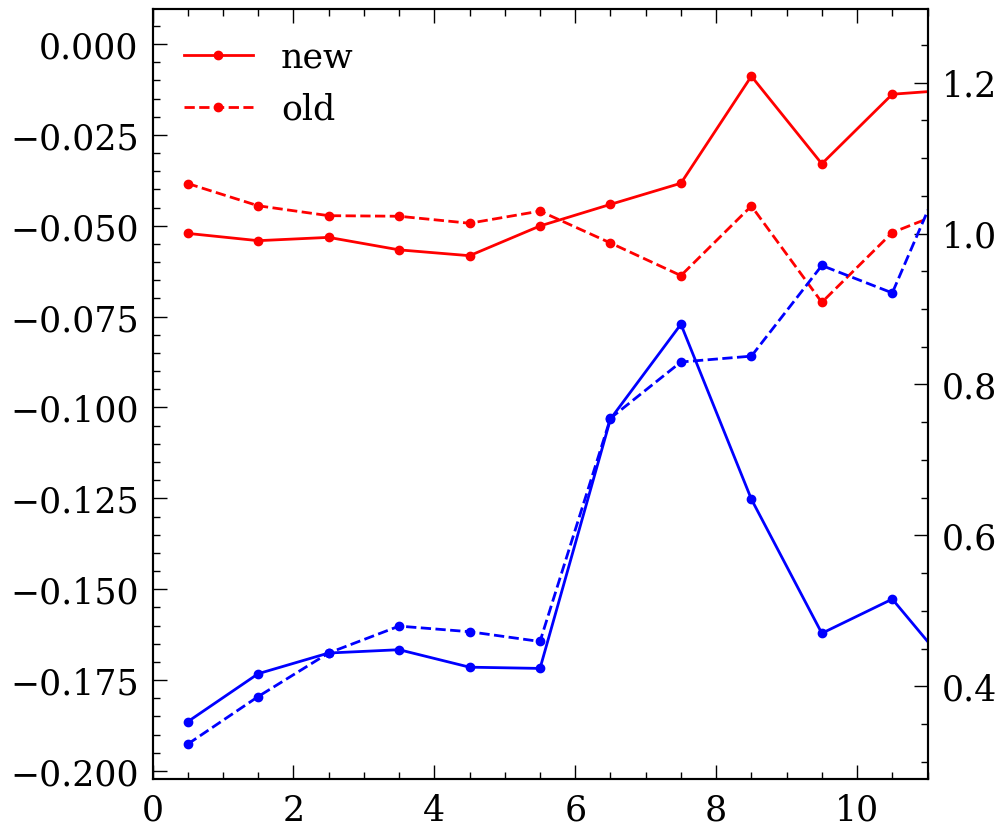

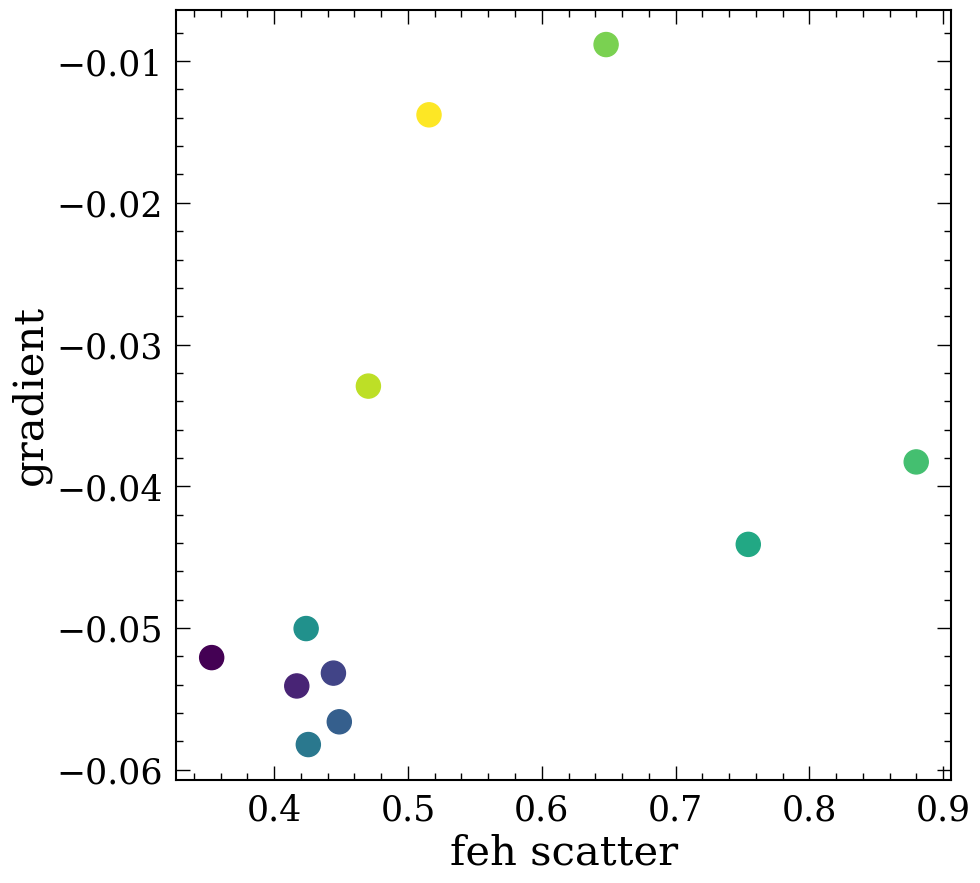

In [274]:
#df_org = pd.read_csv('g2.79e12_fehscatter_simdata.csv')
df_org = pd.read_csv('g7.55e11_fehscatter_simdata.csv')

m = (ages<=10.5)

plt.plot(ages, slopes_rbir, 'r-o',label='new')
plt.plot(df_org['age'], df_org['slopes_rbir'], 'r--o',label='old')
plt.legend()
plt.twinx()
plt.plot(ages, fehscatter, 'b-o')
plt.plot(df_org['age'], df_org['fehscatter'], 'b--o')
plt.xlim([0,11])

plt.figure()
plt.scatter(np.array(fehscatter)[m], np.array(slopes_rbir)[m], c=np.array(ages)[m], s=300)
plt.xlabel('feh scatter')
plt.ylabel('gradient')
#p = fitpoints(fehscatter, slopes_rbir)
#print(np.mean(abs((slopes_rbir-p(fehscatter))/slopes_rbir)))


